In [1]:
import os
import h5py
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
from PIL import ImageOps

import matplotlib.pyplot as plt

In [2]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset

train_dir = r"C:\Users\roobe\PKG - HER2 tumor ROIs_v3\Yale_trastuzumab_response_cohort\patches\train2"
val_dir = r"C:\Users\roobe\PKG - HER2 tumor ROIs_v3\Yale_trastuzumab_response_cohort\patches\test2"

class HistogramEqualization:
    def __call__(self, img):
        return ImageOps.equalize(img)  # 이미지 대비를 자동으로 맞춤

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # 크기 조정
    transforms.ToTensor(),               # 이미지 -> 텐서
    transforms.Normalize([0.5]*3, [0.5]*3)  # 정규화
])



# 증강 transform
aug_transform = transforms.Compose([
    HistogramEqualization(),          # Histogram Equalization 먼저 적용->명암 균형 정규화
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),# 밝기, 대비, 채도, 색조 무작위 조정
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ImageFolder로 원본 및 증강 데이터셋 생성
base_dataset = datasets.ImageFolder(root=train_dir, transform=base_transform)
aug_dataset = datasets.ImageFolder(root=train_dir, transform=aug_transform)

# 두 데이터셋 합치기 → 이미지 수 2배
train_dataset = ConcatDataset([base_dataset] + [aug_dataset]*5)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 검증 데이터셋은 증강 없이
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 확인
print("클래스 목록:", base_dataset.classes)

클래스 목록: ['nonresponder', 'responder']


In [3]:
# device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Current device is', device)

# for reproducibility
torch.manual_seed(2023)
if device == 'cuda':
    torch.cuda.manual_seed_all(2023)

Current device is cuda


In [4]:
import torchvision.models as models

# 사전 학습된 ResNet-18 모델 불러오기
model = models.resnet18(weights="IMAGENET1K_V1")

model.eval()  # 추론 모드로 설정
model.fc = nn.Linear(model.fc.in_features, 2) # PCam은 양성/음성 2클래스
model = model.to(device)
learning_rate = 0.0001
epochs = 20
# define loss & optimizer
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
train_batch = len(train_loader)
val_batch = len(val_loader)

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('Learning started.')

# 스케줄러 정의 (성능 기반 자동 감소)-> 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=2, verbose=True)

train_loss_list = []
train_acc_list = []

val_loss_list = []  
val_acc_list = []

best_val_loss = 10**9
patience_limit = 5
patience_check = 0

for epoch in range(epochs):
    train_loss = 0
    correct = 0

    model.train()
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss / train_batch
        correct += (torch.argmax(Y_pred, 1) == Y).sum()

    train_acc = (100 * correct / len(train_loader.dataset))
    train_acc_list.append(train_acc.item())
    train_loss_list.append(train_loss.item())

    # validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        correct = 0

        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.to(device)

            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            val_loss += loss / val_batch
            correct += (torch.argmax(Y_pred, 1) == Y).sum()

        val_acc = (100 * correct / len(val_loader.dataset))
        val_acc_list.append(val_acc.item())
        val_loss_list.append(val_loss.item())

    # 스케줄러 적용 (val loss 기준)
    scheduler.step(val_loss.item())

    print("[Epoch %2d] loss %.4f  acc %.2f, val loss %.4f  val acc %.2f"
          % (epoch + 1, train_loss, train_acc, val_loss, val_acc))

    # Early stopping
    if val_loss.item() > best_val_loss:
        patience_check += 1
        if patience_check >= patience_limit: 
            print('Early Stopping!')
            break
    else:
        best_val_loss = val_loss.item()
        patience_check = 0 

print('Learning Finished!')  

Learning started.
[Epoch  1] loss 0.3263  acc 85.29, val loss 1.0763  val acc 65.51
[Epoch  2] loss 0.1585  acc 93.71, val loss 1.6719  val acc 62.48
[Epoch  3] loss 0.1014  acc 96.14, val loss 1.4514  val acc 66.74
Epoch 00004: reducing learning rate of group 0 to 8.0000e-05.
[Epoch  4] loss 0.0779  acc 97.15, val loss 2.0461  val acc 61.53
[Epoch  5] loss 0.0494  acc 98.26, val loss 2.2224  val acc 62.06
[Epoch  6] loss 0.0405  acc 98.58, val loss 2.0687  val acc 61.81
Early Stopping!
Learning Finished!


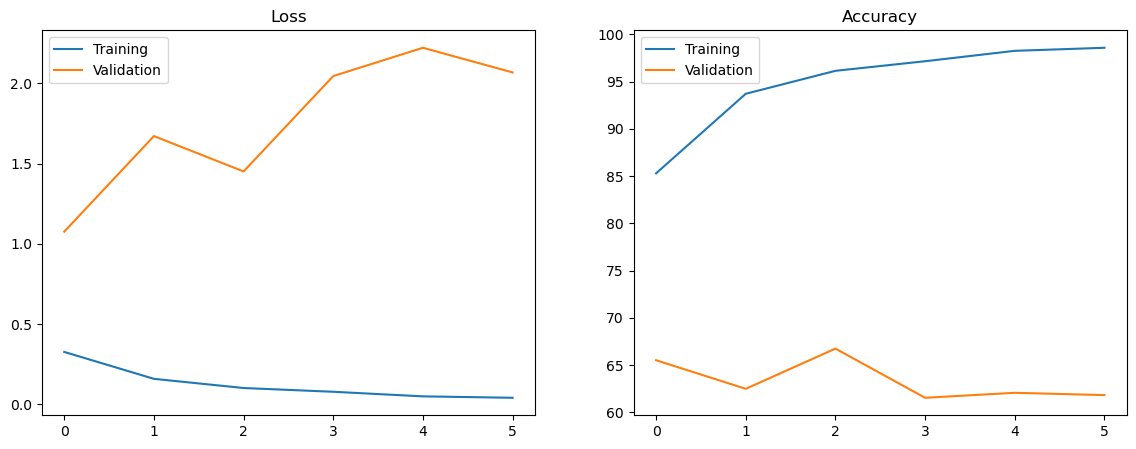

In [8]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(range(len(train_loss_list)), train_loss_list, range(len(val_loss_list)), val_loss_list)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(range(len(train_acc_list)), train_acc_list, range(len(val_acc_list)),val_acc_list)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.show()

In [9]:
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

y_true = []
y_score = []

with torch.no_grad():
    correct = 0

    for X, Y in val_loader:
        X = X.to(device)
        Y = Y.to(device)

        Y_pred = model(X)

        # accuracy 계산
        prediction = torch.argmax(Y_pred, dim=1)
        correct += (prediction == Y).sum().item()

        # AUROC 계산용 데이터 누적
        y_true.extend(Y.cpu().numpy())  # 정답 라벨 누적
        prob = F.softmax(Y_pred, dim=1).cpu().numpy()  # 예측 확률 누적
        y_score.extend(prob)

# 리스트 → numpy 배열 변환
y_true = np.array(y_true)  # 이미 클래스 번호 형태면 argmax 불필요
y_score = np.array(y_score)

# Accuracy 출력
accuracy = 100 * correct / len(val_loader.dataset)
print('Test set Accuracy: %.2f' % accuracy)

# AUROC 출력
roc_auc = roc_auc_score(y_true, y_score[:, 1],average='macro') #멀티 어쩌구 옵션은 이진 분류에서는 쓰면 안됨/roc-arc에서 양성을 얼마나 잘 판단하는지 구하므로 positive 클래스에 해당하는 확률만 필요
print('AUROC (macro avg): %.4f' % roc_auc)

Test set Accuracy: 61.81
AUROC (macro avg): 0.6757
